# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from biokey.data import DataInterface
import biokey.tools
from biokey.tools import parallel_process
import json
import random
# This makes plots render inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import ujson as json
import matplotlib.pyplot as plt
import pickle

In [3]:
% matplotlib inline

In [4]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [5]:
key_press_count = data.get_dwells().key.value_counts()
mask = list(string.ascii_uppercase)
mask.extend(['ESCAPE', 'ENTER', 'SPACE', 'CONTROL', 'META', 'BACKSPACE', 'SHIFT'])

In [6]:
datasets = data.get_all_sets()
# for u in datasets:
#     datasets[u] = biokey.tools.filter_sets(datasets[u], to_include=mask)

# Building Profile Using Threshold

In [7]:
from scipy.stats import ttest_ind_from_stats

class Node(object):
    def __init__(self, name):
        self.name = name
        self.children = {}
        self.stats = None
        self.parent = None
    def add(self, hash1):
        self.children[hash1.name] = hash1
        self.parent = self
        return hash1
    def goto(self, name):
        if(name in self.children):
            return self.children[name]

class Profile(object):
    def __init__(self, df, threshold, trim=None):
        self.trimmed = trim
        self.threshold = threshold
        if data is not None and threshold is not None:
            self._build_profile(df, threshold)
            if trim:
                self.profile = self.profile.loc[self.profile['count'] >= trim]
                self.profile = self.profile.loc[np.array(pd.Series(self.profile.index).apply(lambda x: (len(x.split('-')) <= 3) | (len(set(x.split('-'))) > 1)))]
                self._build_tree()
    
    def _build_profile(self, df, t):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = None
        seqs = []
        count = -1
        for row in df.itertuples():
            count += 1
            row = {
                'key': row.key_code,
                'down': row.down,
                'up': row.up,
                'interval': row.interval,
                'count': count
            }
            if start == None:
                # First after threshold
                start = row
            else:
                # Nth after threshold - queue as starters
                inner_queue.append(row)
            # Add it to the chain
            chain.append(str(row['key']))
            seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
            # If threshold is not met then start again
            if row['interval'] > t:
                for i in range(len(inner_queue)):
                    start = inner_queue[i]
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(row['key']))
                        seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
                chain = []
                inner_queue = []
                start = None
        # Aggregate sequences
        self.seqs = pd.DataFrame(seqs)
        s = self.seqs.copy()
        s.loc[:,'log_duration'] = np.log(s.duration)
        seq_dur = s.groupby('seq').aggregate(['mean', 'std', 'count']).log_duration
        # Fill missing values with a proxy
        seq_dur['std'] = seq_dur['std'].fillna((seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean'])
        self.profile = seq_dur
        self._build_tree()
    
    def update_profile(self, df):
        self.profile = df
        self._build_tree()
    
    def diversify(self, other_profile):
        compared_profiles = pd.merge(self.profile, other_profile.profile, left_index=True, right_index=True)
        compared_profiles['pvalue'] = compared_profiles.apply((lambda x: ttest_ind_from_stats(x.mean_x, x.std_x, x.count_x, x.mean_y, x.std_y, x.count_y, False).pvalue), axis=1)
        new_profile = compared_profiles.loc[compared_profiles.pvalue < 0.05,['mean_x', 'std_x', 'count_x']]
        new_profile.columns = ['mean', 'std', 'count']
        self.update_profile(new_profile)
        
    def _build_tree(self):
        self.root = Node('root')
        for s, row in self.profile.iterrows():
            n = self.root
            for k in s.split('-'):
                new = n.goto(k)
                if not new:
                    new = n.add(Node(k))
                n = new
            n.stats = row.to_dict()
            
    def trim(self, n):
        "Returns a new profile, trimmed to sequences with n instances"
        new_p = Profile(None, self.threshold, n)
        new_p.profile = self.profile.loc[self.profile['count'] >= n]
        new_p.seqs = self.seqs.loc[self.seqs.seq.isin(self.profile.index)]
        new_p._build_tree()
        return new_p
    
    def search_tree(self, path):
        "Search tree for the node at a given list path"
        n = self.root
        for p in path:
            new = n.goto(p)
            if not new:
                return None
            n = new
        return n
    
    def features(self):
        return np.array(self.profile.index)

    def test_distance(self, path, duration):
        "Returns the probability that a typed path's duration was the profiles's"
        node = self.search_tree(path)
        if node is None or node.stats is None:
            return -1
        stats = node.stats
        return np.exp(-np.square((np.log(duration)-stats['mean']))/(2*np.square(stats['std'])))
        
    def test_window(self, df):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = -1
        instances = {}
        results = {}
        
        for f in self.features():
            instances[f] = []
            results[f] = 0
        for row in df.itertuples():
            if start == -1:
                start = row.down
            else:
                inner_queue.append(row)
            chain.append(str(row.key))
            seq = '-'.join(chain)
            if seq in instances:
                instances[seq].append(self.test_distance(chain, row.up - start))
            if row.interval > self.threshold:
                for i in range(len(inner_queue)):
                    start = inner_queue[i].down
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(r.key))
                        seq = '-'.join(chain)
                        if seq in instances:
                            instances[seq].append(self.test_distance(chain, r.up - start))
                chain = []
                inner_queue = []
                start = -1
                
        for f in instances:
            durations = instances[f]
            if len(durations) > 0:
                results[f] = np.mean(durations)
        return pd.Series(results)

In [8]:
userid_valid = 'e85b3844-5af0-47ea-bf51-62da4b4efc39'
userid_valid = '1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f'

train = datasets[userid_valid].train
test = datasets[userid_valid].test

SEQ_THRESHOLD = 150
SEQ_OCCURANCE_THRESHOLD = 30

In [9]:
p = Profile(train.loc[train.is_user], SEQ_THRESHOLD, trim=SEQ_OCCURANCE_THRESHOLD)

In [10]:
def deagg_strokes(df):
    df = df.copy()
    ups = df[['actual_user','up', 'key_code', 'is_user']]
    ups.columns = ['user_id', 'key_time', 'key_code', 'is_user']
    ups['direction'] = 'u'

    downs = df[['actual_user','down', 'key_code', 'is_user']]
    downs.columns = ['user_id', 'key_time', 'key_code', 'is_user']
    downs['direction'] = 'd'

    return pd.concat([ups, downs], ignore_index=True).sort_values('key_time').reset_index(drop=True)

In [11]:
train_strokes = deagg_strokes(train)
test_strokes = deagg_strokes(test)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
def get_sequences(strokes):
    strokes = strokes.copy()
    last_key = None
    seq_number = 0
    downs = {}
    current_seq =  []
    running_seqs = {}
    SEQ_THRESHOLD = 150
    completed_seqences = []
    for _, key in tqdm(strokes.iterrows(), total=len(strokes)):
        if key.direction == 'd':
            new_key = {
                'key': key.key_code,
                'time': key.key_time,
                'seq_number': seq_number
            }
            seq_number += 1
            if last_key is not None and new_key['time'] - last_key['time'] > SEQ_THRESHOLD:
                # Not continuing sequence
                current_seq = []
            current_seq.append(new_key)
            running_seqs[key.key_code] = list(current_seq)
            last_key = new_key
        else:
            finished_section = running_seqs[key.key_code]
            running_seqs[key.key_code] = None
            if finished_section != None:
                seq = ''
                finish_time = key.key_time
                finishing_key = finished_section[-1]
                if finishing_key is None:
                    pass
                else:
                    while len(finished_section) > 0:
                        start_key = finished_section.pop()
                        seq = str(start_key['key']) + ('-' + seq if len(seq) > 0 else '')
                        duration = finish_time - start_key['time']
                        completed_seqences.append({
                            'seq': seq,
                            'duration': duration,
                            'start': start_key['seq_number'],
                            'end': finishing_key['seq_number'],
                            'is_user': key.is_user,
                            'score': p.test_distance(seq.split('-'), duration)
                        })
    seqs = pd.DataFrame(completed_seqences)[['seq', 'start', 'end', 'duration', 'score', 'is_user']]
    y_vals = seqs.groupby('end').is_user.first().astype(np.int16).to_dict()
    return seqs.loc[seqs.score >= 0].reset_index(), y_vals

In [13]:
train_seqs, train_y = get_sequences(train_strokes)
test_seqs, test_y = get_sequences(test_strokes)

100%|██████████| 1651222/1651222 [03:56<00:00, 6970.93it/s]


# Build Frames

In [14]:
def frame_dictionary(seq_to_frame, frame_index):
    try:
        in_past = seq_to_frame.loc[(seq_to_frame.end < frame_index)]
        raw = in_past.loc[in_past.end == frame_index-1].groupby('seq').duration.mean().apply(np.log).to_dict()
        start_age = frame_index - in_past.start
        r40 = in_past.loc[(start_age <= 40)].groupby('seq').score.mean().to_dict()
        r100 =in_past.loc[(start_age <= 100)].groupby('seq').score.mean().to_dict()
    except:
        return None
    return {
        'x_raw': raw,
        'x_40': r40,
        'x_100': r100
    }

In [15]:
def train_frame(i):
    return {
        'x': frame_dictionary(train_seqs, i),
        'y': train_y[i]
    }

def test_frame(i):
    return {
        'x': frame_dictionary(test_seqs, i),
        'y': test_y[i]
    }

In [ ]:
print('Generating Training Frames')
train_frames = parallel_process(range(101, len(train_seqs)), train_frame, front_num=1, n_jobs=36)
print('Dumping Training Frames')
pickle.dump(train_frames, open('./windowed_train_frames_connor.p', 'wb'))

Generating Training Frames


100%|██████████| 1.11M/1.11M [13:56<00:00, 1.33kit/s]   
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/concurrent/futures/process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/concurrent/futures/process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 83, in put
    raise Full
queue.Full



In [ ]:
print('Generating Testing Frames')
test_frames = parallel_process(range(101, len(test_seqs)), test_frame, front_num=1, n_jobs=36)
print('Dumping Training Frames')
pickle.dump(test_frames, open('./windowed_test_frames_connor.p', 'wb'))

In [162]:
train_frames = pickle.load(open('./windowed_train_frames.p', 'rb'))
test_frames = pickle.load(open('./windowed_test_frames.p', 'rb'))

# Make the Arrays

In [ ]:
gaussian = p.profile[["mean", "std"]].rename(columns=lambda c: {"mean":"mean", "std":"stdev"}[c])
gaussian['i'] = 1
gaussian.i = gaussian.i.cumsum()-1
gaussian_profile = gaussian.T.to_dict()

In [ ]:
def blowout_frame(f):
    result = {
        'x': {
            'x_raw': np.zeros(len(p.features())),
            'x_40': np.full(len(p.features()), 0.5),
            'x_100': np.full(len(p.features()), 0.5)
        },
        'y': f['y']
    }
    for x in f['x']:
        for seq in f['x'][x]:
            result['x'][x][int(gaussian_profile[seq]['i'])] = f['x'][x][seq]
    return result

In [ ]:
def parse_frame(f, na_val):
    array = np.full(len(p.features()), na_val)
    for seq in f:
        array[int(gaussian_profile[seq]['i'])] = f[seq]
    return array

In [ ]:
lookback = 100
def generate_frame(frames, index):
    # TODO: THIS IS SLOW
    arrays = [blowout_frame(f) for f in frames[index-lookback+1:index+1]]
    return {
        'x_raw': np.array([a['x']['x_raw'] for a in arrays]),
        'x_100': np.array([a['x']['x_100'] for a in arrays]),
        'x_40': np.array([a['x']['x_40'] for a in arrays])
    }, arrays[-1]['y']

In [ ]:
def generate_batch(frames, batch_size=32):
    num_samples = len(frames)
    while True:
        x_raws = []
        x_100s = []
        x_40s = []
        y_vals = []
        for i in range(batch_size):
            successful = False
            attempts = 0
            while not successful and attempts < 20:
                try:
                    index = random.randint(lookback, num_samples-lookback)
                    selected = frames[index-lookback+1:index+1]
                    # x, y = generate_frame(frames, )
                    x_raw = []
                    x_100 = []
                    x_40 = []
                    for f in selected:
                        x_raw.append(parse_frame(f['x']['x_raw'], 0))
                        x_100.append(parse_frame(f['x']['x_100'], 0.5))
                        x_40.append(parse_frame(f['x']['x_40'], 0.5))
                    y = frames[index]['y']
                    successful = True
                    x_raws.append(x_raw)
                    x_100s.append(x_100)
                    x_40s.append(x_40)
                    y_vals.append(y)
                except Exception as err:
                    attempts += 1
                    pass
        yield {
            'x_raw': np.array(x_raws),
            'x_100': np.array(x_100s),
            'x_40': np.array(x_40s)
        }, np.array(y_vals)

In [182]:
def generate_seq(frames, batch_size=32):
    num_samples = len(frames)
    x_raws = []
    x_100s = []
    x_40s = []
    y_vals = []
    index = lookback
    for i in range(batch_size):
        successful = False
        attempts = 0
        while not successful and attempts < 20:
            try:
                selected = frames[index-lookback+1:index+1]
                # x, y = generate_frame(frames, )
                x_raw = []
                x_100 = []
                x_40 = []
                for f in selected:
                    x_raw.append(parse_frame(f['x']['x_raw'], 0))
                    x_100.append(parse_frame(f['x']['x_100'], 0.5))
                    x_40.append(parse_frame(f['x']['x_40'], 0.5))
                y = frames[index]['y']
                successful = True
                x_raws.append(x_raw)
                x_100s.append(x_100)
                x_40s.append(x_40)
                y_vals.append(y)
            except Exception as err:
                attempts += 1
                pass
        index += 1
    return {
        'x_raw': np.array(x_raws),
        'x_100': np.array(x_100s),
        'x_40': np.array(x_40s)
    }, np.array(y_vals)

In [184]:
generate_seq(train_frames, 1)[0]['x_100'][0].shape

(100, 353)

# Neural Net

In [167]:
from keras.models import Model
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Input, concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

In [168]:
input_features = len(p.features())
input_feature_dimensions = 2 # score, count
lookback_window = 100

input_shape = (lookback_window, input_features)

output_shape = (1)

In [169]:
# create model
input_100 = Input(input_shape, name='x_100')
# lstm_100 = CuDNNLSTM(32, return_sequences=True)(input_100)
lstm_100 = LSTM(32)(input_100)

input_40 = Input(input_shape, name='x_40')
# lstm_40 = CuDNNLSTM(32, return_sequences=True)(input_40)
lstm_40 = LSTM(32)(input_40)

input_raw = Input(input_shape, name='x_raw')
# lstm_raw = CuDNNLSTM(32, return_sequences=True)(input_raw)
lstm_raw = LSTM(32)(input_raw)

# input_interval = Input((1,), name='interval')
# lstm_interval = CuDNNLSTM(32)(input_interval)

merge_layer = concatenate([lstm_100, lstm_40, lstm_raw])

# Deep Connected Layer
# merge_layer = Dense(64, activation='tanh')(merge_layer)
# merge_layer = Dense(64, activation='tanh')(merge_layer)
merge_layer = Dense(64, activation='tanh')(merge_layer)

merge_layer = Dense(32, activation='tanh')(merge_layer)
merge_layer = Dense(16, activation='tanh')(merge_layer)

output = Dense(output_shape, activation='sigmoid')(merge_layer)

ensemble_model = Model(inputs=[input_100, input_40, input_raw], outputs=[output])

# compile model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
run_name = str(datetime.now()).replace(':','.').replace('.','_')
filepath="./gaussian-lstm-models/%s-weights-connor-{epoch:02d}-{val_loss:.2f}.hdf5" % run_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = TensorBoard(log_dir='./Graph/LSTM_Connor_Ensemble_%s/' % run_name, histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

ensemble_model.fit_generator(generate_batch(train_frames), validation_data=generate_batch(test_frames), validation_steps=100, epochs=10, steps_per_epoch=500, callbacks=callbacks_list)


In [ ]:
ensemble_model.fit_generator(generate_batch(train_frames), validation_data=generate_batch(test_frames), validation_steps=100, epochs=10, steps_per_epoch=500, callbacks=callbacks_list)


In [ ]:
def get_model(model):
    gaussian = p.profile[["mean", "std"]].rename(columns=lambda c: {"mean":"mean", "std":"stdev"}[c])
    gaussian['i'] = 1
    gaussian.i = gaussian.i.cumsum()-1
    gaussian
    return {
        'model': model.get_config(),
        'weights': [w.tolist() for w in model.get_weights()],
        'gaussianProfile': gaussian.T.to_dict()
    }
encoded_model = get_model(ensemble_model)
with open('./keras-model-test/ensemble-small-connor.json', 'w') as fout:
        json.dump(encoded_model, fout)

In [190]:
x_test, y_test = generate_seq(sim_frames, 10000)

In [191]:
y_tests = y_test.flatten()
y_test_preds = ensemble_model.predict(x_test).flatten()

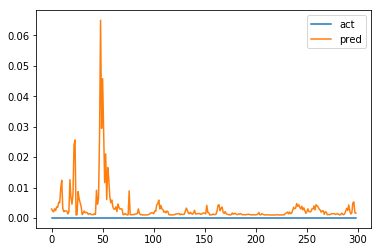

In [192]:
pd.DataFrame({'pred': y_test_preds, 'act': y_tests}).plot()

In [193]:
len(sim_frames)

626

# Validate Results

In [170]:
model_def = json.load(open('./keras-model-test/ensemble-small.json', 'r'))

In [173]:
ensemble_model.set_weights([np.array(w) for w in model_def['weights']])

In [180]:

def sim_frame(i):
    return {
        'x': frame_dictionary(sim_seqs, i),
        'y': sim_y[i]
    }

sim_strokes = pd.read_csv('./train_strokes.csv')
sim_seqs, sim_y = get_sequences(sim_strokes)

print('Generating Training Frames')
sim_frames = parallel_process(range(101, len(sim_seqs)), sim_frame, front_num=1, n_jobs=36)

100%|██████████| 1000/1000 [00:00<00:00, 6402.85it/s]

Generating Training Frames



100%|██████████| 625/625 [00:00<00:00, 2.67kit/s]
625it [00:00, 243131.14it/s]


# Random Verification Stuff

In [433]:
lookback = 100
frame_shape = (lookback, len(p.features()))
x_raw = np.zeros(frame_shape)
x_40 = np.full(frame_shape, 0.5)
x_100 = np.full(frame_shape, 0.5)
gaussian_profile = gaussian.T.to_dict()

current = 300 - lookback + 1
for i in range(lookback):
    frame_index = current + i
    # Get Mean Vals
    raw = seq_to_frame.loc[seq_to_frame.end == frame_index-1].groupby('seq').duration.mean().apply(np.log).to_dict()
    r40 = seq_to_frame.loc[(seq_to_frame.end < frame_index) & (frame_index - seq_to_frame.start <= 40)].groupby('seq').score.mean().to_dict()
    r100 = seq_to_frame.loc[(seq_to_frame.end < frame_index) & (frame_index - seq_to_frame.start <= 100)].groupby('seq').score.mean().to_dict()
    # Fill Array
    for f in raw:
        x_raw[i,int(gaussian_profile[f]['i'])] = raw[f]
    for f in r40:
        x_40[i,int(gaussian_profile[f]['i'])] = r40[f]
    for f in r100:
        x_100[i,int(gaussian_profile[f]['i'])] = r100[f]

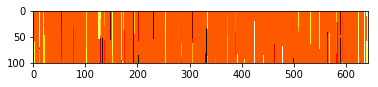

In [398]:
plt.imshow(j_100, cmap='hot', interpolation='nearest')
plt.show()

In [412]:
j_100 = np.array(ja['x_100'])
j_40 = np.array(ja['x_40'])
j_raw = np.array(ja['x_raw'])

In [423]:
pd.DataFrame(j_100).to_csv('java_frame.csv')
pd.DataFrame(x_100).to_csv('python_frame.csv')

In [418]:
np.absolute((j_100 - x_100)).sum()

4.956589231781906

In [419]:
np.absolute(j_raw - x_raw).sum()

184.1527547848026

In [420]:
np.absolute(j_40 - x_40).sum()

9.249068095360757

In [421]:
diff_vals = pd.DataFrame({'p':x_100[np.round(j_100, 4) != np.round(x_100, 4)], 'j':j_100[np.round(j_100, 4) != np.round(x_100, 4)]})
diff_vals['diff'] = (diff_vals.p - diff_vals.j).abs()
diff_vals

In [354]:
def get_difs(x, j):
    return (np.round(x, 4) != np.round(j, 4))

In [410]:
gaussian.loc[gaussian.i == 20]

mean      5.945019
stdev     0.255426
i        22.000000
Name: 14-14-14, dtype: float64

In [432]:
p.profile.to_csv('features.csv')